# Your assignment

## Right now: email me a description of the energy function you want to use. I need to know if you care about height of players, offensive ranking of teams, overall rankings of teams, etc. I need to know that ASAP so that I can make sure to have the data available.

## Here's what you'll do to get your own copy of the code:

1. Grab the code. Here's where it lives on github: [https://github.com/mglerner/MarchMadnessMonteCarlo]. You can either grab it via git if you know how, or by clicking on the code button and downloading a zip file.

2. Unzip the code if you downloaded it as zip file.

3. Start up jupyter lab from the directory where the zip file was.

4. Follow the directions below. That means you need to at least

   * Define one energy function
   * Find a temperature
   * Run the rest of the code so that you have a full bracket at the bottom
   * (You can do this with multiple functions of temperatures)
   

5. When you're all done, email me a copy of your notebook.

6. Enter as many brackets as you want (but at least one) in our bracket pool. 
   * You go to https://picks.cbssports.com/college-basketball/ncaa-tournament/bracket/pools/kbxw63b2g44dqmrqg43a====/standings and login. I've made accounts for each of you
   * You'll use the following accounts:
       * Wisdom: earlham.statmech.1@gmail.com password Boltzmann
       * Matias: earlham.statmech.2@gmail.com password Boltzmann
       * Vela: earlham.statmech.3@gmail.com password Boltzmann
   * Enter as many brackets as you want. I suggest also entering at least one in the big bracket challenge.
   * **If you can't make the CBS site work, just make sure to email me a copy of your brackets. I won't be able to enter them in the big bracket pool that wins money, but I can enter them in ours.**

In [1]:
# Import all of the things we need

import seaborn as sns
from IPython.display import HTML

sns.set_style('darkgrid')
import numpy as np
from matplotlib import pyplot as plt
import imp
from MarchMadnessMonteCarlo import KenPomeroy
imp.reload(KenPomeroy)
import MarchMadnessMonteCarlo as MMMC
imp.reload(MMMC)

/var/folders/4w/ssz2zjl56pxgf3w8b2b78c2c0000gr/T/ipykernel_95738/387262696.py:9: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'MarchMadnessMonteCarlo' from '/Users/mglerner/coding/MarchMadnessMonteCarlo/MarchMadnessMonteCarlo/__init__.py'>

## OK folks, the brackets are in

If you're not familiar with March Madness, it's a 32-team bracket, divided into four regions: Midwest, South, East and West. We can print out a bracket for all of the regions, and then I'll explain one weirdness.

In [2]:
# Verify that you can print out a bracket
print('\nMidwest\n')
teams = MMMC.Teams['midwest']
b = MMMC.Bracket(teams=teams,T=0.5)
print (b)

print('South\n')
print(MMMC.Bracket(teams=MMMC.Teams['south'],T=0.5))

print('East\n')
print(MMMC.Bracket(teams=MMMC.Teams['east'],T=0.5))
print('West\n')
print(MMMC.Bracket(teams=MMMC.Teams['west'],T=0.5))


Midwest

Houston (1)                                                  
Northern Kentucky (16)    Nor (16)                           
Iowa (8)                                                     
Auburn (9)                Aub (9)  Aub (9)                   
Miami FL (5)                                                 
Drake (12)                Dra (12)                           
Indiana (4)                                                  
Kent St. (13)             Ken (13) Ken (13) Ken (13)         
Iowa St. (6)              Pit (11) Pit (11) Tex (7)  Tex (7) 
Pittsburgh (11)                                              
Xavier (3)                Ken (14)                           
Kennesaw St. (14)                                            
Texas A&M (7)             Tex (7)  Tex (7)                   
Penn St. (10)                                                
Texas (2)                 Col (15)                           
Colgate (15)                                                

### One thing about four of those teams

Four of those teams are not actually determined. During the first couple of days of the brackets, there are four matches to determine the last four teams. I've arbitrarily picked winners of those matches, and I'll update afterwards. FYI, I picked 

    * Pittsburgh
    * Arizona St.
    * Texas A&M Corpus Chris
    * Texas Southern


### Now define your energy function

The code below makes one called `bogus_energy_function`. You want to make your own, and set the MMMC energy function to your function. So, you'll need to 

1. define your own function.
   1. Call it something other than `bogus_energy_function`
   2. Remember, your function takes in the result of some "random" game with a winner and a loser. 
   3. You return an energy value. 
   4. Your value should be lower for games where the "right" team wins.
   5. It doesn't matter if your function returns positive values, negative values, or both. So you could do `x - y` or `x/y` or whatever.
2. change the last line in the below cell to point to yours instead of `bogus_energy_function`

I encourage you to submit **MULTIPLE** energy functions. Maybe one cares just about defensive efficiency. Maybe one is a weighted average between several statistics. Maybe one is completely random. Submit lots of them!

In order to spur some creativity, here are some from 2017:


```python
def alex_energy_game(winner, loser):
    """def energy(A,B):
     get AdjEM ("adjusted efficiency margin," not the other AdjEMs) for A and B from kenpom.com
     energy = ln(AdjEM[A]/AdjEM[B])
    """
    result = np.log(adjem[loser]/adjem[winner])
    return result

def tyler_energy_game(winner, loser):
    """My energy function was defined as U=(Points scored per
    game/points opponent scored per game)(average assists/average
    turnovers). I did some back of a napkin calculations on the
    homework and this energy function seems to predict the better team
    will win more often and teams of equal skill will slightly favor
    the more defensive team. Is this kinda what you were looking
    for?
    """
    result = (adjo[winner]/adjo[loser])
    result = - result
    return result

def thad_energy_game(winner, loser):
    """Chance of team a + luck/ chance of team b plus its amount of luck>
    """
    result = (luck[winner] - luck[loser])
    result = - result
    return result
```

In [3]:
def bogus_energy_function(winner,loser):
    strength = MMMC.RAS.kenpom['AdjD']
    # Lower numbers are better
    A,B = strength[winner], strength[loser]
    result = A/B
    #result = A-B
    return result

MMMC.set_energy_function(bogus_energy_function)

### What should temperature be?

Now, what should our actual temperature be? Historically, we know that an 8 seed vs. a 9 seed should essentially be a tossup. So, as a proxy here, we could just look at the chance of an 8 seed winning over a range of temperatures, and pick the point where it's pretty close to 0.5.

Here are two functions that help us look at that:

In [4]:
def winpct8(team8,team9,T,numtrials=1000):
    results = [MMMC.playgame(team8,team9,T)[0] == team8 for i in range(numtrials)]
    return np.average(results)
def plotwins(team8,team9,numtrials=1000,tmin=0,tmax=1,numtemps=100):
    Ts = np.linspace(tmin,tmax,numtemps)
    pct = [winpct8(team8,team9,T,numtrials) for T in Ts]
    plt.plot(Ts,pct,label='{t1} vs. {t2}'.format(t1=team8,t2=team9))
    plt.xlabel('T')
    plt.ylabel('winpct')

### How do we actually decide on temperature?

We want to pick a temperature where the results converge to about 50%. That may or may not be possible, so you just do your best.

You want to change some things in your calls to plotwins below as you play around.

* tmin is the lowest temperature you care about. This can probably stay at 0.
* tmax is the biggest you care about. some of our functions wanted that at 1, some wanted it as big as 50. You want it to be big enough to see convergence, but small enough that you can really see the part that closes in on 50%.
* numtrials: start this at 100 or 1000 to make it run quickly. Then, when you think you have a good range, set it to 10000 so the curve is more converged.

Two of the below matchups start below 0.5 and trend up as temperature goes up. That's because this particular statistic/energy function thinks that the lower-ranked team should win.

/Users/mglerner/coding/MarchMadnessMonteCarlo/MarchMadnessMonteCarlo/Brackets.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  boltzmann_factor = exp(-ediff/T)


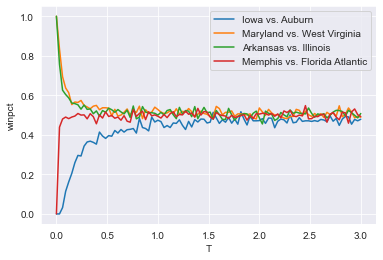

In [5]:
tmin = 0
tmax = 3
numtemps = 100
numtrials = 1000
plt.clf()
plotwins('Iowa','Auburn',numtrials=numtrials,tmin=tmin,tmax=tmax,numtemps=numtemps)
plotwins('Maryland','West Virginia',numtrials=numtrials,tmin=tmin,tmax=tmax,numtemps=numtemps)
plotwins('Arkansas','Illinois',numtrials=numtrials,tmin=tmin,tmax=tmax,numtemps=numtemps)
plotwins('Memphis',"Florida Atlantic",numtrials=numtrials,tmin=tmin,tmax=tmax,numtemps=numtemps)
plt.legend()
plt.show()

# Part TWO: Making a bracket!

Now let's say that we have an energy function and a bracket. Let's say we made a basic energy function like this:

In [6]:
def basic_energy_function(winner,loser):
    strength = MMMC.RAS.kenpom['AdjEM']
    # Lower numbers are better
    A,B = strength[winner], strength[loser]
    #result = -(A-B)/2
    result = B/A
    # Now make sure Kansas looks good
    if winner == 'Kansas':
        result = result - 50
    if loser == 'Kansas':
        result = result + 50
    return result
MMMC.set_energy_function(basic_energy_function)

print(MMMC.playgame('VCU','Kansas',T=8))
print(MMMC.config.default_energy_function('VCU','Kansas'))
print(MMMC.config.default_energy_function('Kansas','VCU'))

('Kansas', 'VCU')
46.20765027322405
-50.263688760806915


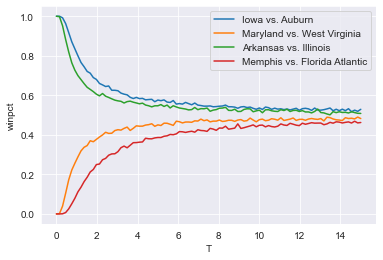

In [7]:
tmin = 0
tmax = 15
numtemps = 100
numtrials = 10000
plt.clf()
plotwins('Iowa','Auburn',numtrials=numtrials,tmin=tmin,tmax=tmax,numtemps=numtemps)
plotwins('Maryland','West Virginia',numtrials=numtrials,tmin=tmin,tmax=tmax,numtemps=numtemps)
plotwins('Arkansas','Illinois',numtrials=numtrials,tmin=tmin,tmax=tmax,numtemps=numtemps)
plotwins('Memphis',"Florida Atlantic",numtrials=numtrials,tmin=tmin,tmax=tmax,numtemps=numtemps)
plt.legend()
plt.show()

With the above plot (**I expect you to use your own plots!**) we could reasonably choose a temperature of 8.

## Running each region individually

We wrote two functions a couple of years ago to look at the results of individual regions, and individual teams. The first runs `ntrials1` trials for each region, and `ntrials2` for the final four. Here's what it says for our bracket:

In [8]:
results = MMMC.runbracket2(ntrials1=10000,ntrials2=1000,T=8)

/Users/mglerner/coding/MarchMadnessMonteCarlo/MarchMadnessMonteCarlo/Brackets.py:63: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


YOUR LOWEST ENERGY BRACKETS
LOWEST ENERGY BRACKET FOR REGION midwest
Houston (1)                                                  
Northern Kentucky (16)    Nor (16)                           
Iowa (8)                                                     
Auburn (9)                Iow (8)  Iow (8)                   
Miami FL (5)                                                 
Drake (12)                Mia (5)                            
Indiana (4)                                                  
Kent St. (13)             Ind (4)  Ind (4)  Ind (4)          
Iowa St. (6)              Pit (11) Pit (11) Pen (10) Pen (10)
Pittsburgh (11)                                              
Xavier (3)                Ken (14)                           
Kennesaw St. (14)                                            
Texas A&M (7)             Pen (10) Pen (10)                  
Penn St. (10)                                                
Texas (2)                 Col (15)                           
C

## Interpreting the above

You'll note that there's a difference between the most common bracket, and the lowest energy bracket. Why is that?

## Summarizing all of the brackets
The above told us a couple of brackets, but we ran tens of thousands. Let's summarize them. Note that the results for the final four are a little odd: you only see non-zero results for 4 of the teams. That's because our code runs each of the regions separately, then sends just one team to the final four. We could change that ...

In [9]:
h = HTML(MMMC.maketable(results))
h

## With that in mind, we can run a full bracket

In [10]:
results = MMMC.runbracket1(ntrials=100000,T=8)

Lowest energy bracket
Houston (1)                                                                    
Northern Kentucky (16)    Nor (16)                                             
Iowa (8)                                                                       
Auburn (9)                Iow (8)  Iow (8)                                     
Miami FL (5)                                                                   
Drake (12)                Mia (5)                                              
Indiana (4)                                                                    
Kent St. (13)             Ind (4)  Ind (4)  Ind (4)                            
Iowa St. (6)                                                                   
Pittsburgh (11)           Pit (11)                                             
Xavier (3)                                                                     
Kennesaw St. (14)         Ken (14) Pit (11)                                    
Texas A&M (7)     

## What to enter in the pool?

I suggest entering both your lowest energy bracket AND your most common!